In [1]:
# Cellule qui gère les imports

import json
import nltk
from textblob import TextBlob
import re
from random import choices
import os
import shutil
import matplotlib.pyplot as plt

nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Cellule qui gère la classe Tweet

# Dictionnaire des utilisateurs avec leur poids
users_weight = {
    "IainLJBrown": 15,
    "byLilyV": 15,
    "andi_staub": 15,
    "YouTube": 5,
    "unikuma_yukkuri": 5,
    "TechTweet24h": 5,
    "DeepLearn007": 5,
    "JolaBurnett": 5,
    "elonmusk": 8,
    "data_nerd": 1,
    "TechXplore_com": 4,
    "ILASColumbia": 3,
    "Indika_AI": 2,
    "Entrepreneur": 2,
    "Kevin_Jackson": 1,
    "Kbuxton90": 9
}

def chose_username() -> str:
    """
    Cette fonction permet de choisir un nom d'utilisateur.
    :return username: Nom d'utilisateur
    """

    # On retourne un nom d'utilisateur aléatoire en fonction de la liste des utilisateurs
    return choices(list(users_weight.keys()), weights=users_weight.values(), k=1)[0]


class Tweet:
    """
    Cette classe permet de créer un objet tweet.
    """

    cleaned_text: str  # Liste des mots du tweet

    def __init__(self, tweet_data: dict):
        """
        Constructeur de la classe Tweet
        :param tweet_data: Dictionnaire contenant les données du tweet
        """

        self.id = tweet_data["id"]
        self.user = chose_username()
        self.text = tweet_data["TweetText"]
        self.clean_text(["#", "@"])
        self.hashtags = []
        self.arobase = []
        self.topics = []
        self.feelings = self.calculate_sentiment()

    def calculate_sentiment(self) -> str:
        """
        Cette fonction permet de calculer le sentiment du tweet.
        :return bool: True si sentiment positif, False sinon
        """
        return "Négatif" if TextBlob(self.text).sentiment.polarity < 0 else "Positif"

    def extract_entities(self):
        """
        Cette fonction permet d'extraire les entités du tweet (hashtags, arobase)
        """

        # On sépare le texte en liste de mots
        text = self.cleaned_text.split()

        # On parcourt chaque mot du tweet
        for word in text.copy():
            if word[0] not in ["#", "@"] or word[1:] == "":
                continue
            if word[0] == "#":  # Si le mot commence par un #
                self.hashtags.append(word[1:])  # On ajoute le mot sans le # à la liste des hashtags
            elif word[0] == "@":  # Si le mot commence par un @
                self.arobase.append(word[1:])  # On ajoute le mot sans le @ à la liste de l'arobase
            text.remove(word)

        self.cleaned_text = " ".join(text)

        nouns = TextBlob(self.cleaned_text).noun_phrases
        for noun in nouns:
            self.topics.append(noun)

    def clean_text(self, excepted_char: list):
        """
        Cette fonction permet de nettoyer le texte du tweet.
        :param excepted_char: Liste des caractères à ne pas remplacer
        """

        cleaned_text = self.text.strip()

        # On remplace les "RT" et les hyperliens par des espaces
        cleaned_text = re.sub("http://\S+|https://\S+", "", cleaned_text)
        cleaned_text = cleaned_text.replace("RT ", " ")

        # On remplace les caractères spéciaux par des espaces sauf si ceux-ci sont dans excepted_char
        cleaned_text = re.sub(fr"[^\w\s{''.join(excepted_char)}]+", "", cleaned_text)

        self.cleaned_text = cleaned_text

In [3]:
# Cellule qui gère les fonctions sur les hashtags

def count_hashtags(tweets: list) -> dict:
    """
    Cette fonction permet de retourner les hashtags avec leur nombre de publications.
    :param tweets: Liste des tweets
    :return hashtags: Dictionnaire des hashtags avec leur nombre de publications
    """

    hashtags = {}  # Dictionnaire des hashtags

    # On parcourt chaque tweet
    for tweet in tweets:
        # On parcourt chaque hashtag du tweet
        for hashtag in tweet.hashtags:
            if hashtag in hashtags:  # Si le hashtag est déjà dans le dictionnaire
                hashtags[hashtag]["occurence"] += 1  # On incrémente le nombre d'occurence du hashtag
                if tweet.user not in hashtags[hashtag]["users_who_used"]:  # Si l'utilisateur n'est pas déjà dans la liste
                    hashtags[hashtag]["users_who_used"].append(tweet.user)  # On ajoute l'utilisateur à la liste des utilisateurs
            else:  # Sinon
                hashtags[hashtag] = {  # On ajoute le hashtag au dictionnaire
                    "occurence": 1,
                    "users_who_used": [tweet.user]
                }

    # On retourne les hashtags avec leur nombre de publications
    return hashtags


def top_hashtags(k: int, hashtags: dict) -> list:
    """
    Cette fonction permet de retourner les k hashtags les plus utilisés.
    :param k: Nombre de hashtags à retourner
    :param hashtags: Liste des hashtags avec leur nombre de publications
    :return top_hashtags: Liste des k hashtags les plus utilisés
    """

    # On retourne les k hashtags les plus utilisés
    return sorted(hashtags, key=lambda hashtag: hashtags[hashtag]["occurence"], reverse=True)[:k]

In [4]:
# Cellule qui gère les fonctions sur les arobases

def count_arobases(tweets: list) -> dict:
    """
    Cette fonction permet de retourner les arobases avec leur nombre de publications.
    :param tweets: Liste des tweets
    :return arobases: Dictionnaire des k arobase les plus utilisés
    """

    arobases = {}  # Dictionnaire de l'arobase

    # On parcourt chaque tweet
    for tweet in tweets:
        # On parcourt chaque arobase du tweet
        for arobase in tweet.arobase:
            if arobase in arobases:  # Si l'arobase est déjà dans le dictionnaire
                arobases[arobase]["occurence"] += 1  # On incrémente le nombre d'occurence de l'arobase
                arobases[arobase]["id"].append(tweet.id)  # On ajoute l'id du tweet à la liste des id de l'arobase
                if tweet.user not in arobases[arobase]["users_who_mentionned"]:  # Si l'utilisateur n'est pas déjà dans la liste
                    arobases[arobase]["users_who_mentionned"].append(tweet.user)  # On ajoute l'utilisateur à la liste des utilisateurs
            else:  # Sinon
                # On ajoute l'arobase au dictionnaire
                arobases[arobase] = {
                    "occurence": 1,
                    "id": [tweet.id],
                    "users_who_mentionned": [tweet.user]
                }

    # On retourne les arobases avec leur nombre de publications
    return arobases


def top_arobases(k: int, arobases: dict) -> list:
    """
    Cette fonction permet de retourner les k arobase les plus utilisés.
    :param k: Nombre d'arobases à retourner
    :param arobases: Liste des arobases avec leur nombre de publications
    :return top_arobases: Liste des k arobase les plus utilisés
    """

    # On retourne les k arobase les plus utilisés
    return sorted(arobases, key=lambda arobase: arobases[arobase]["occurence"], reverse=True)[:k]


def tweetid_arobases(user: str, arobases: dict) -> list:
    """
    Cette fonction permet de retourner les id des tweets qui ont utilisé un arobas donné.
    :param user: Arobase à rechercher
    :param arobases: Liste des arobases avec leur nombre de publications
    :return tweetid_arobases: Liste des id des tweets qui ont utilisé l'arobase
    """

    # On retourne les id des tweets qui ont utilisé l'arobase
    return arobases[user]["id"]

In [5]:
# Cellule qui gère les fonctions sur les topics

def count_topics(tweets: list) -> dict:
    """
    Cette fonction permet de retourner les topics avec leur nombre de publications.
    :param tweets: Liste des tweets
    :return topics: Dictionnaire des topics avec leur nombre de publications
    """

    topics = {}  # Dictionnaire des topics

    # On parcourt chaque tweet
    for tweet in tweets:
        # On parcourt chaque topic du tweet
        for topic in tweet.topics:
            if topic in topics:  # Si le topic est déjà dans le dictionnaire
                topics[topic] += 1  # On incrémente le nombre d'occurence du topic
            else:  # Sinon
                topics[topic] = 1  # On ajoute le topic au dictionnaire

    # On retourne les topics avec leur nombre de publications
    return topics


def top_topics(k: int, topics: dict) -> list:
    """
    Cette fonction permet de retourner les k topics les plus utilisés.
    :param k: Nombre de topics à retourner
    :param topics: Liste des topics avec leur nombre de publications
    :return top_topics: Liste des k topics les plus utilisés
    """

    # On retourne les k topics les plus utilisés
    return sorted(topics, key=topics.get, reverse=True)[:k]

In [6]:
def count_user(tweets: list) -> dict:
    """
    Cette fonction permet de retourner les utilisateurs avec leur nombre de publications.
    :param tweets: Liste des tweets
    :return users: Dictionnaire des utilisateurs avec leur nombre de publications
    """

    users = {}  # Dictionnaire des utilisateurs

    # On parcourt chaque tweet
    for tweet in tweets:
        if tweet.user in users:  # Si l'utilisateur est déjà dans le dictionnaire
            users[tweet.user]["occurence"] += 1  # On incrémente le nombre d'occurence de l'utilisateur
            users[tweet.user]["id"].append(tweet.id)  # On ajoute l'id du tweet à la liste des id de l'utilisateur
        else:  # Sinon
            users[tweet.user] = {  # On ajoute l'utilisateur au dictionnaire
                "occurence": 1,
                "id": [tweet.id]
            }
    
    # On retourne les utilisateurs avec leur nombre de publications
    return users

def top_users(k: int, users: dict) -> list:
    """
    Cette fonction permet de retourner les k utilisateurs les plus actifs.
    :param k: Nombre d'utilisateurs à retourner
    :param users: Liste des utilisateurs avec leur nombre de publications
    :return top_users: Liste des k utilisateurs les plus actifs
    """

    # On retourne les k utilisateurs les plus actifs
    return sorted(users, key=lambda user: users[user]["occurence"], reverse=True)[:k]

In [7]:
# Cellule qui gère les données brutes

def create_data(tweets: list):
    """
    Cette fonction permet de créer les données brutes.
    :param tweets: Liste des tweets
    """
    
    # On crée le dossier data s'il n'existe pas sinon on le vide
    if not os.path.exists("data"):
        os.mkdir("data")
    else:
        shutil.rmtree("data")
        os.mkdir("data")
        
    # On crée des variables qui contiennent les données des hashtags, arobase, utilisateurs et topics.
    hashtags = count_hashtags(tweets)
    arobase = count_arobases(tweets)
    users = count_user(tweets)
    topics = count_topics(tweets)

    # On crée un fichier qui contient les données des hashtags, arobase, utilisateurs et topics.
    with (open("data/hashtags.json", "w", encoding="UTF-8") as file1,
            open("data/arobases.json", "w", encoding="UTF-8") as file2, 
            open("data/users.json", "w", encoding="UTF-8") as file3, 
            open("data/topics.json", "w", encoding="UTF-8") as file4):
        json.dump(hashtags, file1, indent=4)
        json.dump(arobase, file2, indent=4)
        json.dump(users, file3, indent=4)
        json.dump(topics, file4, indent=4)
        
    # On crée des variables qui contiennent les données des tops hashtags, arobase, utilisateurs et topics.
    top_hashtag = top_hashtags(10, hashtags)
    top_arobase = top_arobases(10, arobase)
    top_user = top_users(10, users)
    top_topic = top_topics(10, topics)
    
    # On fait le top 10 des hashtags, arobase, utilisateurs et topics.
    with open("data/top.json", "w", encoding="UTF-8") as file:
        number = range(1,11)
        json.dump({
            "top_hashtags": dict(zip(number, top_hashtag)),
            "top_arobases": dict(zip(number, top_arobase)),
            "top_users": dict(zip(number, top_user)),
            "top_topics": dict(zip(number, top_topic)),
        }, file, indent=4)

In [8]:
# Cellule qui gère les données graphiques

# On crée un histogramme des hashtags les plus utilisés
def create_histogram_hashtags(tweets: list):
    """
    Cette fonction permet de créer un histogramme des hashtags les plus utilisés.
    :param tweets: Liste des tweets
    """
    
    # On crée des variables qui contiennent les données des hashtags.
    hashtags = count_hashtags(tweets)
    topk = top_hashtags(10, hashtags)
    
    # On crée un histogramme des hashtags les plus utilisés.
    plt.figure(figsize=(20, 10))
    plt.bar(topk, [hashtags[hashtag]["occurence"] for hashtag in topk])
    plt.title("Histogramme des hashtags les plus utilisés")
    plt.xlabel("Hashtags")
    plt.ylabel("Nombre de publications")
    plt.savefig("data/histogram_hashtags.png")
    plt.show()

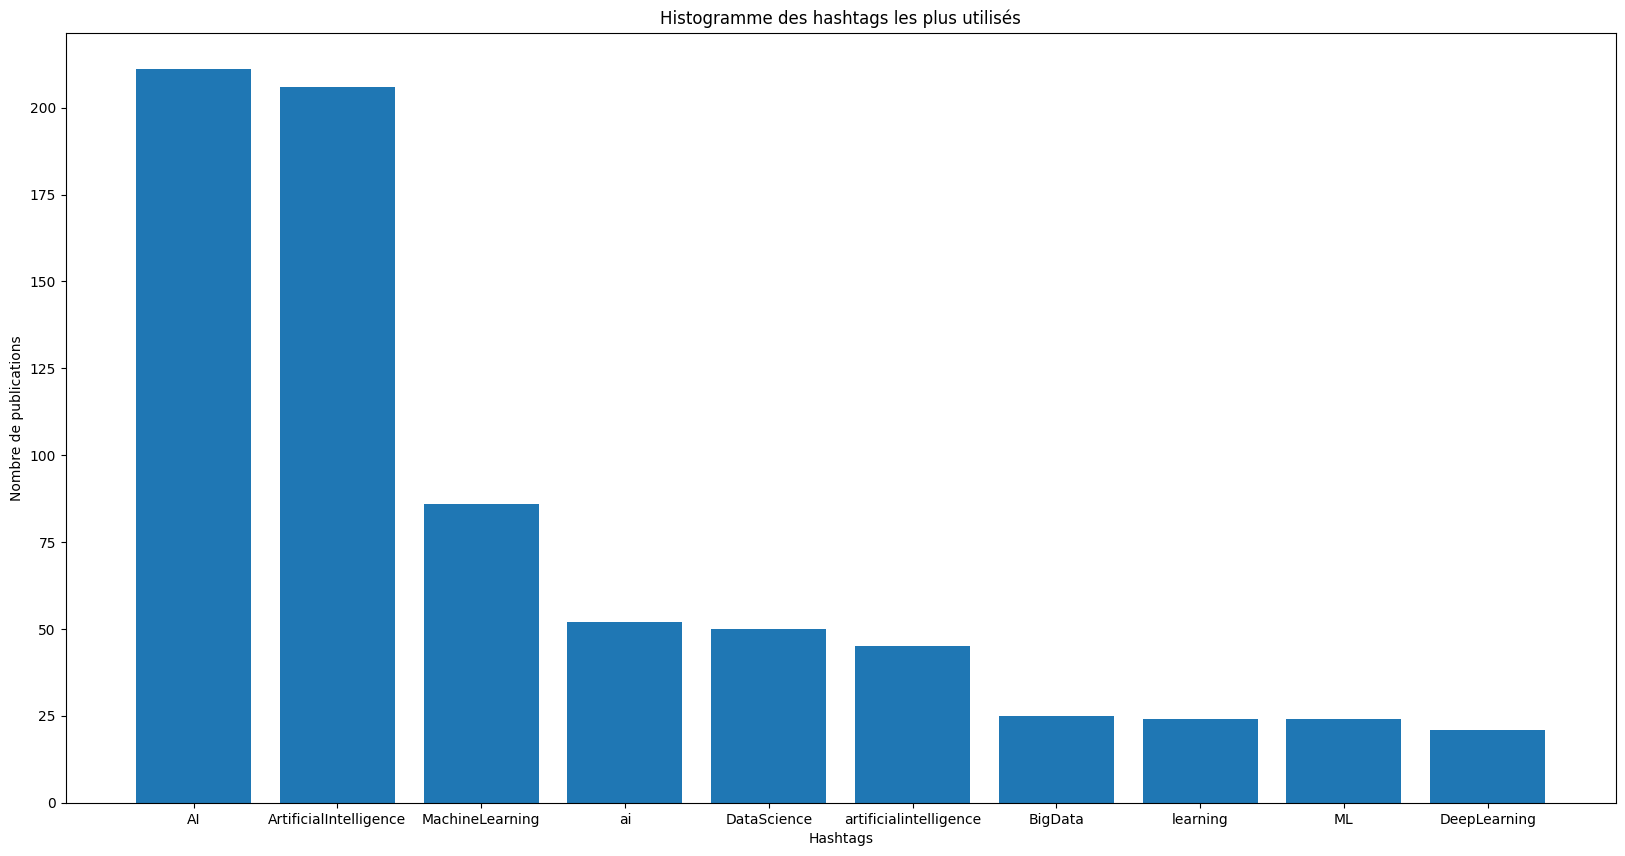

In [9]:
# Cellule qui gère la fonction main

def main(filename: str):
    """
    Fonction principale
    :param filename: Nom du fichier json  
    """

    tweets = []  # Liste des tweets

    # On ouvre le fichier json et on le charge dans une liste de dictionnaire
    with open(filename, "r", encoding="UTF-8") as file:
        data = [json.loads(line) for line in file]

    # On parcourt chaque tweet
    for tweet_data in data:
        tweet = Tweet(tweet_data)  # On crée un objet Tweet
        tweet.extract_entities()  # On extrait les entités du tweet (hashtags, arobase, sentiment)
        tweets.append(tweet)  # On ajoute le tweet à la liste des tweets
        
    create_data(tweets)
    create_histogram_hashtags(tweets)
        

if __name__ == "__main__":
    main("aitweets.json")